# Importing the libraries

In [211]:
from datetime import datetime, timedelta
program_start = time.time()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import tensorflow as tf
print(tf.__version__)
import math
from sklearn.metrics import mean_squared_error
import os

2.2.0


# Importing the dataset

In [212]:
len(pd.bdate_range(start=fya, end=yesterday))

1565

In [213]:
yesterday = date.today() - timedelta(days = 1)
print(yesterday)
fya = yesterday - timedelta(days = 365 * 5)
print(fya)

2020-07-19
2015-07-21


In [214]:
ticker = 'TSLA'
TIINGO_API_KEY = '0d89b22b2baae6031d933255d95b27b45630fa18'
#api_key=os.environ.get('TIINGO_API_KEY')
df = pdr.get_data_tiingo(ticker, api_key=TIINGO_API_KEY, 
                         start = fya, end = yesterday)

# Data preprocessing

## Converting JSON to CSV

In [215]:
df.to_csv('{0}.csv'.format(ticker))
df.head()

close      high     low    open   volume  \
symbol date                                                                   
TSLA   2015-07-21 00:00:00+00:00  266.77  273.5000  266.55  270.05  6108686   
       2015-07-22 00:00:00+00:00  267.87  269.4400  260.86  261.27  3104960   
       2015-07-23 00:00:00+00:00  267.20  269.9000  265.27  269.65  2227239   
       2015-07-24 00:00:00+00:00  265.41  271.0900  263.92  267.38  2836498   
       2015-07-27 00:00:00+00:00  253.01  264.4321  250.79  262.43  4694192   

                                  adjClose   adjHigh  adjLow  adjOpen  \
symbol date                                                             
TSLA   2015-07-21 00:00:00+00:00    266.77  273.5000  266.55   270.05   
       2015-07-22 00:00:00+00:00    267.87  269.4400  260.86   261.27   
       2015-07-23 00:00:00+00:00    267.20  269.9000  265.27   269.65   
       2015-07-24 00:00:00+00:00    265.41  271.0900  263.92   267.38   
       2015-07-27 00:00:00+00:00    253.01  264.4321  250.79   262.43   

                                  adjVolume  divCash  splitFactor  
symbol date                                                        
TSLA   2015-07-21 00:00:00+00:00    6108686      0.0          1.0  
       2015-07-22 00:00:00+00:00    3104960      0.0          1.0  
       2015-07-23 00:00:00+00:00    2227239      0.0          1.0  
       2015-07-24 00:00:00+00:00    2836498      0.0          1.0  
       2015-07-27 00:00:00+00:00    4694192      0.0          1.0

## Forming dataframe of close prices

In [216]:
df1 = df.reset_index()['close']

In [217]:
df1.shape

(1258,)

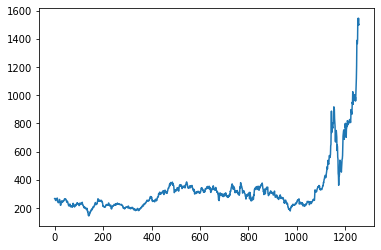

In [218]:
plt.plot(df1)

## Feature scaling using MinMax Scaler (Values between 0 to 1)

In [219]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [220]:
df1.shape

(1258, 1)

## Splitting dataset into training set and test set sequentialy

In [221]:
training_size = int(len(df1)*0.65)
test_size = len(df1) - training_size
train_data, test_data = (df1[0:training_size, :], 
                         df1[training_size:len(df1), :1])
print(train_data.shape)
print(test_data.shape)

(817, 1)
(441, 1)


In [222]:
pd.DataFrame(train_data).head()

,0
0,0.087782
1,0.088566
2,0.088088
3,0.086812
4,0.077970


In [223]:
pd.DataFrame(test_data).head()

,0
0,0.094784
1,0.091354
2,0.085742
3,0.082954
4,0.083632


## Creating array of independent and dependent variables(X_train, y_train, X_test, y_test)

In [251]:
def create_dataset(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    dataY.append(dataset[(i+time_step), 0])
  return np.array(dataX), np.array(dataY)

In [252]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [226]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.087782,0.088566,0.088088,0.086812,0.077970,0.086391,0.085678,0.087796,0.087340,0.082947,...,0.061305,0.062709,0.061747,0.066689,0.062980,0.063494,0.061832,0.062367,0.059222,0.057654
1,0.088566,0.088088,0.086812,0.077970,0.086391,0.085678,0.087796,0.087340,0.082947,0.087432,...,0.062709,0.061747,0.066689,0.062980,0.063494,0.061832,0.062367,0.059222,0.057654,0.059472
2,0.088088,0.086812,0.077970,0.086391,0.085678,0.087796,0.087340,0.082947,0.087432,0.090178,...,0.061747,0.066689,0.062980,0.063494,0.061832,0.062367,0.059222,0.057654,0.059472,0.052305
3,0.086812,0.077970,0.086391,0.085678,0.087796,0.087340,0.082947,0.087432,0.090178,0.073064,...,0.066689,0.062980,0.063494,0.061832,0.062367,0.059222,0.057654,0.059472,0.052305,0.053418
4,0.077970,0.086391,0.085678,0.087796,0.087340,0.082947,0.087432,0.090178,0.073064,0.070482,...,0.062980,0.063494,0.061832,0.062367,0.059222,0.057654,0.059472,0.052305,0.053418,0.055208


In [250]:
print(X_train.shape)

(716, 100, 1)


In [227]:
pd.DataFrame(y_train).head()

,0
0,0.059472
1,0.052305
2,0.053418
3,0.055208
4,0.064777


In [228]:
pd.DataFrame(X_test).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.094784,0.091354,0.085742,0.082954,0.083632,0.107299,0.103277,0.122075,0.133513,0.136329,...,0.121989,0.125654,0.107763,0.101038,0.094749,0.094535,0.094784,0.100168,0.105003,0.099612
1,0.091354,0.085742,0.082954,0.083632,0.107299,0.103277,0.122075,0.133513,0.136329,0.132799,...,0.125654,0.107763,0.101038,0.094749,0.094535,0.094784,0.100168,0.105003,0.099612,0.103605
2,0.085742,0.082954,0.083632,0.107299,0.103277,0.122075,0.133513,0.136329,0.132799,0.138091,...,0.107763,0.101038,0.094749,0.094535,0.094784,0.100168,0.105003,0.099612,0.103605,0.104318
3,0.082954,0.083632,0.107299,0.103277,0.122075,0.133513,0.136329,0.132799,0.138091,0.143054,...,0.101038,0.094749,0.094535,0.094784,0.100168,0.105003,0.099612,0.103605,0.104318,0.093957
4,0.083632,0.107299,0.103277,0.122075,0.133513,0.136329,0.132799,0.138091,0.143054,0.144573,...,0.094749,0.094535,0.094784,0.100168,0.105003,0.099612,0.103605,0.104318,0.093957,0.089721


In [229]:
pd.DataFrame(y_test).head()

,0
0,0.103605
1,0.104318
2,0.093957
3,0.089721
4,0.088281


In [230]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [231]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [232]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
lstm_16 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_17 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [233]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), 
          epochs=100, batch_size=64, verbose=1)

Epoch 1/100
12/12 [==============================] - 4s 337ms/step - loss: 0.0032 - val_loss: 0.0433
Epoch 2/100
12/12 [==============================] - 3s 210ms/step - loss: 9.6862e-04 - val_loss: 0.0236
Epoch 3/100
12/12 [==============================] - 3s 214ms/step - loss: 4.9285e-04 - val_loss: 0.0079
Epoch 4/100
12/12 [==============================] - 2s 192ms/step - loss: 2.7718e-04 - val_loss: 0.0073
Epoch 5/100
12/12 [==============================] - 2s 205ms/step - loss: 2.3399e-04 - val_loss: 0.0087
Epoch 6/100
12/12 [==============================] - 2s 193ms/step - loss: 2.1664e-04 - val_loss: 0.0069
Epoch 7/100
12/12 [==============================] - 2s 201ms/step - loss: 2.1478e-04 - val_loss: 0.0070
Epoch 8/100
12/12 [==============================] - 2s 191ms/step - loss: 2.2185e-04 - val_loss: 0.0067
Epoch 9/100
12/12 [==============================] - 2s 206ms/step - loss: 2.1083e-04 - val_loss: 0.0069
Epoch 10/100
12/12 [==============================] - 2s 20

In [234]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

In [235]:
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

In [236]:
math.sqrt(mean_squared_error(y_train, train_pred))

280.14552829587876

In [237]:
math.sqrt(mean_squared_error(y_test, test_pred))

495.09994690095203

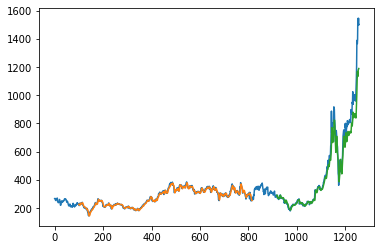

In [238]:
look_back = 100
train_pred_plot = np.empty_like(df1)
train_pred_plot[:, :] = np.nan
train_pred_plot[look_back:len(train_pred)+look_back, :] = train_pred
test_pred_plot = np.empty_like(df1)
test_pred_plot[:,:] = np.nan
test_pred_plot[len(train_pred)+(look_back*2)+1:len(df1)-1, :] = test_pred
plt.plot(scaler.inverse_transform(df1))
plt.plot(train_pred_plot)
plt.plot(test_pred_plot)
plt.show()

In [239]:
pd.DataFrame(test_data).tail()

,0
436,0.965094
437,0.979171
438,1.000000
439,0.967647
440,0.967790


In [240]:
X_in = test_data[340:].reshape(1, -1)
X_in.shape

(1, 101)

In [241]:
temp_in = list(X_in)
temp_in = temp_in[0].tolist()

In [242]:
pd.DataFrame(temp_in).head()

,0
0,0.467961
1,0.452907
2,0.381741
3,0.373889
4,0.427821


In [243]:
list_output = []
n_steps = 100
i = 0
while(i<30):
  if (len(temp_in) > 100):
    X_in = np.array(temp_in[1:])
    #print("{0} day input {1}".format(i, X_in))
    X_in = X_in.reshape(1, -1)
    X_in = X_in.reshape((1, n_steps, 1))
    y_hat = model.predict(X_in, verbose=0)
    #print("{0} day output {1}".format(i, y_hat))
    temp_in.extend(y_hat[0].tolist())
    temp_in = temp_in[1:]
    list_output.extend(y_hat.tolist())
    i += 1
  else:
    X_in = X_in.reshape((1, n_steps, 1))
    y_hat = model.predict(X_in, verbose=0)
    #print(y_hat)
    temp_in.extend(y_hat[0].tolist())
    #print(len(temp_in))
    list_output.extend(y_hat.tolist())
    i +=1

  pd.DataFrame(list_output).head()

In [244]:
day_new = np.arange(1, 100)
day_pred = np.arange(101, 131)

In [245]:
len(df1)

1258

In [246]:
df3 = df1.tolist()
df3.extend(list_output)

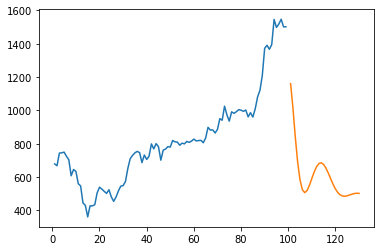

In [247]:
plt.plot(day_new, scaler.inverse_transform(df1[1159:]))
plt.plot(day_pred, scaler.inverse_transform(list_output))

In [248]:
program_end = time.time()
print(f"Runtime: {program_end - program_start}")

Runtime: 278.2465491294861
